# Testing production and degradation on ABC

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

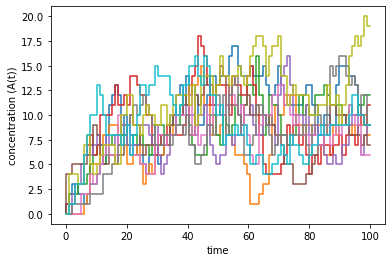

In [2]:
np.random.seed(3)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 100, 100)

for i in range(10):
    values = model.simulate(k, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0, 0.5], [0.3, 2])

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

# Rejection ABC

In [24]:
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(3.5)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     3      0.333333333      0:00.0
2     10     0.2              0:00.1
3     16     0.1875           0:00.1
20    199    0.100502513      0:00.6
40    537    0.0744878957     0:01.6
60    804    0.0746268657     0:02.4
80    1095   0.0730593607     0:03.3
100   1353   0.07390983       0:04.0
120   1567   0.0765794512     0:04.6
140   1884   0.0743099788     0:06.4
160   2143   0.0746616892     0:07.3
180   2458   0.0732302685     0:08.1
200   2860   0.0699300699     0:09.1
220   3095   0.071082391      0:09.7
240   3369   0.071237756      0:10.5
260   3621   0.0718033692     0:11.1
280   3937   0.0711201422     0:11.9
300   4216   0.0711574953     0:12.7
320   4499   0.0711269171     0:13.6
340   4669   0.0728207325     0:14.1
360   4973   0.0723909109     0:15.1
380   5302   0.0716710675     0:16.7
400   5708   0.0700770848     0:17.7
420   5956   0.0705171256     0:18.4
440   6209   0.0

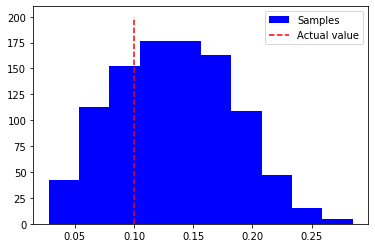

In [26]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
plt.legend()
plt.show()

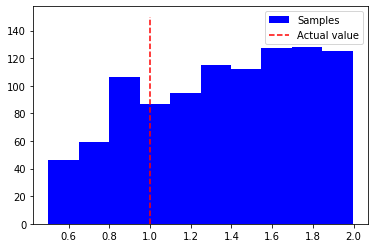

In [28]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=150, label="Actual value", color="red")
plt.legend()
plt.show()

# PMC

In [3]:
np.random.seed(3)

abc = pints.ABCController(error_measure, log_prior, method=pints.ABCPMC)

# set the threshold
abc.sampler().set_threshold(10000)

# set target number of samples
# try this
abc.set_n_samples(10)

# setting the number of generations
abc.sampler().set_n_generations(20)

# setting the threshold ratio
abc.sampler().set_t_ratio(0.99)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using PMC ABC
Running in sequential mode.
xs = [array([0.20992425, 1.70998077])], i=1
thetas = [[0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.20992425 1.70998077]
 [0.         0.        ]]
xs = [array([0.03031137, 1.88223101])], i=2
thetas = [[0.         0.        ]
 [0.20992425 1.70998077]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.03031137 1.88223101]
 [0.         0.        ]]
xs = [array([0.09898616, 1.06707245])], i=3
thetas = [[0.         0.        ]
 [0.20992425 1.70998077]
 [0.03031137 1.88223101]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.0989861

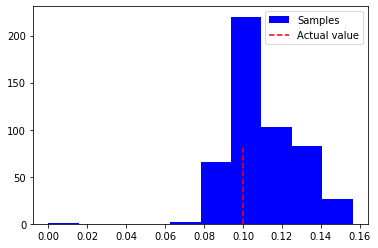

In [14]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=80, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

# ABC SMC

In [22]:
np.random.seed(2)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([9, 6, 4]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=6
Trying t=2, threshold=4
Iter. Eval. Acceptance rate Time m:s
1     655    0.00152671756    0:05.0
2     703    0.00284495021    0:05.5
3     717    0.00418410042    0:05.7
20    940    0.0212765957     0:07.9
40    1414   0.0282885431     0:10.5
60    1660   0.0361445783     0:11.5
80    2098   0.0381315539     0:13.0
100   2429   0.0411692054     0:14.1
120   2735   0.0438756856     0:15.2
140   3156   0.0443599493     0:16.7
160   3519   0.0454674623     0:17.9
180   3838   0.0468994268     0:18.7
200   4372   0.0457456542     0:20.1
220   4868   0.0451930978     0:21.5
240   5248   0.0457317073     0:22.6
260   5607   0.0463706082     0:23.6
280   5969   0.04690903       0:24.6
300   6310   0.0475435816     0:25.5
320   6627   0.0482873095     0:26.3
340   7075   0.0480565371     0:27.8
360   7441   0.048380594      0:28.8
380   7742   0.0490829243     0:29.7
400   8077   0.0495233379     0:30.6
420   8370   0.0501792

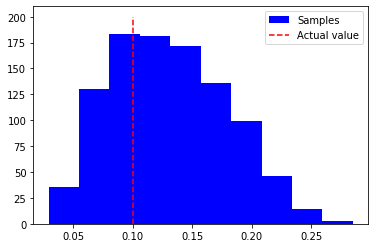

In [26]:
plt.hist(samples[:,0], color="blue", label="Samples")
plt.vlines(x=0.1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()

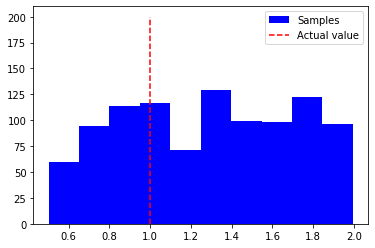

In [27]:
plt.hist(samples[:,1], color="blue", label="Samples")
plt.vlines(x=1, linestyles='dashed', ymin=0, ymax=200, label="Actual value", color="red")
# plt.plot(thetas, true_prob, label="posterior")
plt.legend()
plt.show()